Preparing the dataset for training

In [1]:
import scipy
from glob import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import imageio

def PREPARE_DATASET(batch_size):
    hr_images_path = 'Data\DIV2K_train_HR\*'
    hr_images_path = glob(hr_images_path)
    
    lr_images_ds = []
    hr_images_ds = []
    
    for n in range(batch_size):
        img_path = np.random.choice(hr_images_path, size=batch_size)
        img = imageio.imread(img_path[0])
        
        hr_patch = scipy.misc.imresize(img, (256, 256))
        lr_patch = scipy.misc.imresize(img, (64, 64))

        lr_images_ds.append(lr_patch)
        hr_images_ds.append(hr_patch)
    
    lr_images_ds = np.array(lr_images_ds)/127.5 - 1
    hr_images_ds = np.array(hr_images_ds)/127.5 - 1
    
    return hr_images_ds, lr_images_ds

Defining the model

In [2]:
import scipy

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Add
from keras.layers import PReLU, LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D

from keras.applications import VGG19
from keras.models import Sequential, Model
from keras.optimizers import Adam

import tensorflow.layers as tfl
import matplotlib.pyplot as plt
import numpy as np

import os
import sys

def SRGAN_GEN(input_shape):
    n0 = Input(input_shape)
    n = Conv2D(64, kernel_size=9, strides=1, padding='SAME')(n0)
    n = Activation('relu')(n)
    tmp = n
    
    # Residual blocks
    for i in range(16):
        nn = Conv2D(64, kernel_size=3, strides=1, padding='SAME')(n)
        nn = Activation('relu')(n)
        nn = BatchNormalization(momentum=0.8)(nn)
        nn = Conv2D(64, kernel_size=3, strides=1, padding='SAME')(nn)
        nn = BatchNormalization(momentum=0.8)(n)
        nn = Add()([n, nn])
        n  = nn
    
    n = Conv2D(64, kernel_size=3, strides=1, padding='SAME')(n)
    n = BatchNormalization(momentum=0.8)(n)
    n = Add()([n, nn])
    
    n = UpSampling2D(size=2)(n)
    n = Conv2D(256, kernel_size=3, strides=1, padding='SAME')(n)
    n = Activation('relu')(n)
    
    n = UpSampling2D(size=2)(n)
    n = Conv2D(256, kernel_size=3, strides=1, padding='SAME')(n)
    n = Activation('relu')(n)
    
    nn = Conv2D(3, kernel_size=9, strides=1, padding='SAME')(n)
    
    GEN = Model(inputs=n0, outputs=nn, name="SRGAN_GENERATOR")
    
    return GEN

def SRGAN_DIS(input_shape):
    w_init = tf.random_normal_initializer(stddev=0.02)
    gamma_init = tf.random_normal_initializer(1., 0.02)
    
    n0 = Input(input_shape)
    n = Conv2D(64, kernel_size=4, strides=1, padding='SAME')(n0)
    n = LeakyReLU(alpha=0.2)(n)
    
    n = Conv2D(64 * 2, kernel_size=4, strides=2, padding='SAME')(n)
    n = LeakyReLU(alpha=0.2)(n)
    n = Conv2D(64 * 4, kernel_size=4, strides=2, padding='SAME')(n)
    n = LeakyReLU(alpha=0.2)(n)
    n = BatchNormalization(momentum=0.8)(n)
    n = Conv2D(64 * 8, kernel_size=4, strides=2, padding='SAME')(n)
    n = LeakyReLU(alpha=0.2)(n)
    n = BatchNormalization(momentum=0.8)(n)
    
    n = Conv2D(64 * 16, kernel_size=4, strides=2, padding='SAME')(n)
    n = LeakyReLU(alpha=0.2)(n)
    n = BatchNormalization(momentum=0.2)(n)
    
    n = Conv2D(64 * 32, kernel_size=4, strides=2, padding='SAME')(n)
    n = LeakyReLU(alpha=0.2)(n)
    n = BatchNormalization(momentum=0.8)(n)
    
    n = Conv2D(64 * 16, kernel_size=1, strides=1, padding='SAME')(n)
    n = LeakyReLU(alpha=0.2)(n)
    n = BatchNormalization(momentum=0.8)(n)
    
    n = Conv2D(64 * 8, kernel_size=1, strides=1, padding='SAME')(n)
    n = LeakyReLU(alpha=0.2)(n)
    nn = BatchNormalization(momentum=0.8)(n)
    
    
    n = Conv2D(64 * 2, kernel_size=1, strides=1, padding='SAME')(nn)
    n = LeakyReLU(alpha=0.2)(n)
    n = BatchNormalization(momentum=0.8)(n)
    
    n = Conv2D(64 * 2, kernel_size=3, strides=1, padding='SAME')(n)
    n = LeakyReLU(alpha=0.2)(n)
    n = BatchNormalization(momentum=0.8)(n)
    
    n = Conv2D(64 * 8, kernel_size=3, strides=1, padding='SAME')(n)
    n = LeakyReLU(alpha=0.2)(n)
    n = BatchNormalization(momentum=0.8)(n)
    
    n = Add()([n, nn])
    n = LeakyReLU(alpha=0.2)(n)
    
    no = Dense(1)(n)
    
    DIS = Model(inputs=n0, outputs=no, name="SRGAN_DISCRIMINATOR")
    
    return DIS


def VGG_FEATURES(input_shape):
    vgg = VGG19(weights="imagenet")
    # Set outputs to outputs of last conv. layer in block 3
    # See architecture at: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
    vgg.outputs = [vgg.layers[9].output]

    img = Input(input_shape)

    # Extract image features
    img_features = vgg(img)
    
    VGG_FEATURES = Model(inputs=img, outputs=img_features, name="VGG_FEATURES")
    
    return VGG_FEATURES


Using TensorFlow backend.


Training pipeline

In [3]:
import scipy
from glob import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# define input shape
input_shape = (64, 64, 3)
scale = 4

# Training phase
output_shape = (input_shape[0]*scale, input_shape[1]*scale, input_shape[2])
# read inputs
lr_patch = Input(input_shape)
hr_patch = Input(output_shape)
    
# create optimizer
optimizer = Adam(0.002, 0.5)
    
# building phase
# use vgg feature: no training
vgg_feature = VGG_FEATURES(output_shape)
vgg_feature.trainable = False
vgg_feature.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
print("vgg feature (out metric names):", vgg_feature.metrics_names)
# create the discriminator model
srgan_dis = SRGAN_DIS(output_shape)
srgan_dis.compile(loss='mse', optimizer=optimizer, metrics=['accuracy']) 
print("srgan dis (out metric names):", srgan_dis.metrics_names)
# create srgan complete model
hr_patch = Input(output_shape)
lr_patch = Input(input_shape)
    
srgan_gen = SRGAN_GEN(input_shape)
pred_hr = srgan_gen(lr_patch)
pred_features = vgg_feature(pred_hr)
srgan_dis.trainable = False
real = srgan_dis(pred_hr)
    
srgan_complete = Model([lr_patch, hr_patch], [real, pred_features])
srgan_complete.compile(loss=['binary_crossentropy', 'mse'], loss_weights=[1e-3, 1], optimizer=optimizer)
print("srgan complete (out metric names):", srgan_complete.metrics_names)

def SRGAN_TRAIN(input_shape, scale, n_epoch, batch_size):
    # Train for n epoch
    for n in range(n_epoch):
        print(n)
        # prepare dataset function
        hr_patch, lr_patch = PREPARE_DATASET(batch_size);
        pred_hr = srgan_gen.predict(lr_patch)
        # Train the discriminator
        real = np.ones((batch_size,) + (8, 8, 1))
        fake = np.zeros((batch_size,) + (8, 8, 1)) 
        dis_loss_real = srgan_dis.train_on_batch(hr_patch, real)
        dis_loss_pred = srgan_dis.train_on_batch(pred_hr, fake)
        dis_loss = 0.5 * np.add(dis_loss_real, dis_loss_pred)
        print("dis_loss:", (dis_loss))
        # Train generator
        real = np.ones((batch_size,) + (8, 8, 1)) # why (8, 8, 1) patch must be size 1 ?
        real_features = vgg_feature.predict(hr_patch)
        srgan_loss = srgan_complete.train_on_batch([lr_patch, hr_patch], [real, real_features])
        # print epoch, srgan loss
        if n % 1 == 0:
            print("epoch: %s, srgan_loss: " %(n), (srgan_loss[0]))
            
SRGAN_TRAIN(input_shape, scale=4, n_epoch=10, batch_size=2)

vgg feature (out metric names): ['loss', 'acc']
srgan dis (out metric names): ['loss', 'acc']
srgan complete (out metric names): ['loss', 'SRGAN_DISCRIMINATOR_loss', 'VGG_FEATURES_loss']
0


C:\Users\dwith\AppData\Local\Continuum\miniconda3\envs\cynCNN\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
C:\Users\dwith\AppData\Local\Continuum\miniconda3\envs\cynCNN\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
C:\Users\dwith\AppData\Local\Continuum\miniconda3\envs\cynCNN\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


dis_loss: [8.951375   0.18359375]
epoch: 0, srgan_loss:  8820.94
1
dis_loss: [1.1386591e+02 4.2968750e-02]
epoch: 1, srgan_loss:  930736.94
2
dis_loss: [6.5898636e+01 3.9062500e-02]
epoch: 2, srgan_loss:  349.75082
3
dis_loss: [6.5056887 0.171875 ]
epoch: 3, srgan_loss:  62.771282
4
dis_loss: [3.291615  0.2421875]
epoch: 4, srgan_loss:  57.92716
5
dis_loss: [1.4757651  0.40234375]
epoch: 5, srgan_loss:  63.548447
6
dis_loss: [0.95328325 0.375     ]
epoch: 6, srgan_loss:  44.101482
7
dis_loss: [0.6785485  0.49609375]
epoch: 7, srgan_loss:  64.4734
8
dis_loss: [0.5230864  0.45703125]
epoch: 8, srgan_loss:  55.831596
9
dis_loss: [0.38088474 0.55078125]
epoch: 9, srgan_loss:  70.40949


C:\Users\dwith\AppData\Local\Continuum\miniconda3\envs\cynCNN\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
C:\Users\dwith\AppData\Local\Continuum\miniconda3\envs\cynCNN\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


(-0.5, 255.5, 255.5, -0.5)

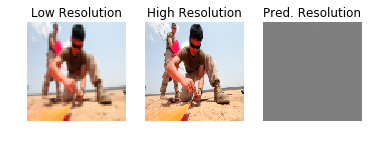

In [10]:
#Try the networks on test image
test_hr, test_lr = PREPARE_DATASET(batch_size=1)
pred_hr = srgan_gen.predict(test_lr)

img_lr = 0.5 * test_lr + 0.5 
img_hr = 0.5 * test_hr + 0.5
pred_hr = 0.5 * pred_hr + 0.5 

figure, axis = plt.subplots(1, 3)

axis[0].imshow(img_lr[0])
axis[0].set_title('Low Resolution')
axis[0].axis('off')

axis[1].imshow(img_hr[0])
axis[1].set_title('High Resolution')
axis[1].axis('off')

axis[2].imshow(pred_hr[0])
axis[2].set_title('Pred. Resolution')
axis[2].axis('off')
